# FFT test
------------------------------
Since it took me 2 whole days of tinkering with the FFT algorithm to figure it out, I guess I'll write some of this down.

## Why?
I wanted to use the FFT algorithm in a Schrödinger solver (by going to $k$-space). But, in order to make sure everything works, I needed to do some sanity-checks with the FFT routines. This ran out of hand quickly, and it took a LONG time for me to figure out what went wrong...

## What?
I wanted to do the FFT of a box function, symmetric around 0. It's a neat enough function, with a simple Fourier transform (the continuous transform is a $\mathrm{sinc}$ function). The box function is symmetric and real, so at the very least, we expect a symmetric and real result from the FFT. (Sanity checks, remember?)

## Caveat #1: Symmetric signal
Defining a symmetric signal is not so trivial when considering samples. Suppose for definitenes we have $N$ samples in some sampling window $L$. We **do not** want something like `linspace(0, L, N)`. Since the signal will be assumed *periodic*, the sample at $L$ will be copy-pasted before 0. That means we have a doubling of samples there! The sampling should actually only go up to a distance $L-L/N$, such that the samples join smoothly with their periodic images. Observe the difference:

In [11]:
using PyPlot
L = 2.0
N = 7
θ(x) = 0.5*(1+sign(x))
hat1(x) = (θ(x + 0.5) - θ(x - 0.5))

xs1 = collect(linspace(-L/2, L/2, N)) # Incorrect sampling
xs2 = collect(linspace(-L/2, L/2*(1-2/N), N)) # Correct sampling
hs1 = hat1(xs1)
hs2 = hat1(xs2);

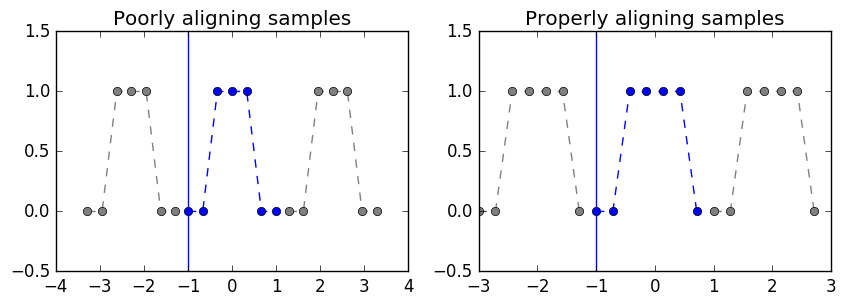

In [12]:
fig = figure("sampling symmetric",figsize=(10,3))
subplot(121)
ax1 = gca()
ax1[:set_ylim]([-0.5, 1.5])
#ax[:set_xlim]([-1, 1])
title("Poorly aligning samples")
plot(xs1-2-L/N, hs1, linestyle="dashed", marker="o", color="grey")
plot(xs1+2+L/N, hs1, linestyle="dashed", marker="o",color="grey")
plot(xs1, hs1, linestyle="dashed", marker="o")
axvline(-L/2)
subplot(122)
ax2 = gca()
title("Properly aligning samples")
ax2[:set_ylim]([-0.5, 1.5])
plot(xs2-2, hs2, linestyle="dashed", marker="o", color="grey")
plot(xs2+2, hs2, linestyle="dashed", marker="o",color="grey")
plot(xs2, hs2, linestyle="dashed", marker="o")
axvline(-L/2)
show()

See how, in the "well aligned" case, there's actually a sample *less* at the end?
The difference is that the symmetric signal will indeed yield a real FFT. The slightly unsymmetric one, will have significant complex contributions.

In [13]:
println("(Max) Imaginary part of the 'not-so symmetric' signal's FFT: ", maximum(imag(fft(hs1))))
println("(Max) Imaginary part of the symmetric signal's FFT: ", maximum(imag(fft(hs2))))

(Max) Imaginary part of the 'not-so symmetric' signal's FFT: 0.9749279121818236
(Max) Imaginary part of the symmetric signal's FFT: 0.0


There's still quite a bit wrong with this signal, however.

## Caveat 2: Symmetric around *what*?
FFT doesn't know about $x$-values. All FFT knows is a set of samples, labeled from $0,\ldots, N-1$, which it will transform into a new set of samples, labeled $0, \ldots, N-1$. So, while the samples, when done right, **DO** form a symmetric signal, its FFT will not be the nice $\mathrm{sinc}$ function we'd like.

Rather, we're going to need to symmetrize our box function around $n=0$, which is completely different from $x=0$.

Observe:

In [14]:
hat2(x) = 1 - (θ(x - 0.5) - θ(x - 1.5))
N = 101
ns = collect(0:N-1)
xs1 = collect(linspace(-L/2, L/2*(1-2/N), N)) # Incorrect sampling
xs2 = collect(linspace(0.0, L*(1-1/N), N)) # Correct sampling
hs1 = hat1(xs1)
hs2 = hat2(xs2)
cs1 = real(fft(hs1))
cs2 = real(fft(hs2));

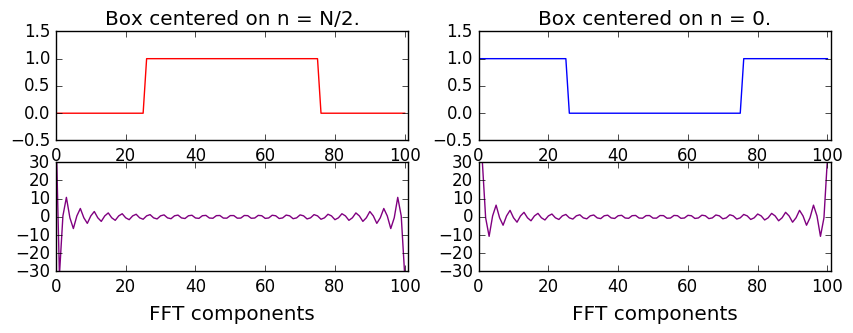

In [15]:
fig = figure("Box positions", figsize=(10,3))
subplot(221)
ax1 = gca()
ax1[:set_ylim]([-0.5, 1.5])
ax1[:set_xlim]([0.0, N])
title("Box centered on n = N/2.")
plot(ns, hs1, color="red")

subplot(222)
ax2=gca()
ax2[:set_ylim]([-0.5, 1.5])
ax2[:set_xlim]([0.0, N])
title("Box centered on n = 0.")
plot(ns, hs2, color="blue")

subplot(223)
ax3 = gca()
ax3[:set_ylim]([-30, 30])
ax3[:set_xlim]([0.0, N])
title("FFT components", y=-0.5)
plot(ns, cs1, color="purple")

subplot(224)
ax4 = gca()
ax4[:set_ylim]([-30, 30])
ax4[:set_xlim]([0, N])
title("FFT components", y=-0.5)
plot(ns, cs2, color="purple")
show()

Significantly different, no? Imagine my confusion... Note how the FFT components are now all real, thanks to the correct (symmetric) sampling.

And now, for the third and last confusion. The $\mathrm{sinc}$ function.

## Caveat 3: $\mathrm{sinc}$, you say?
Okay, so, suppsedly, I should be able to fit this Fourier spectrum to some kind of $\mathrm{sinc}$? Well, I guess I could try...

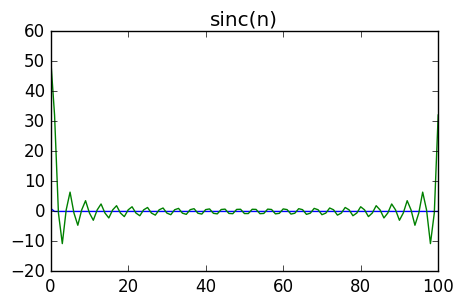

In [16]:
sincvals1 = sinc(ns)
fig = figure("Sinc tryouts", figsize=(5,3))
ax = gca()
title("sinc(n)")
plot(ns, sincvals1)
plot(ns, cs2)
show()

Well, that didn't really work. I probably need to scale it by $L$ and $N$ somehow in order for them to match. Let's see, we need to stretch the $x$-range, and increase the amplitude?

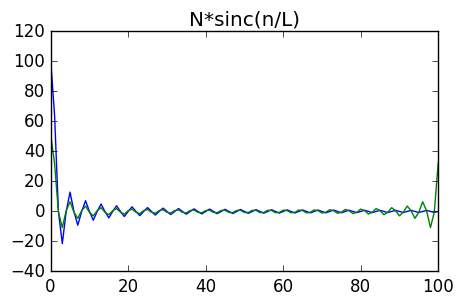

In [17]:
sincvals2 = N*sinc(ns/L)
fig = figure("Sinc tryouts", figsize=(5,3))
ax = gca()
title("N*sinc(n/L)")
plot(ns, sincvals2)
plot(ns, cs2)
show()

Hey, not bad! Though, I'm not sure where those factors came from, really. All wikipedia tells me is that, for a continuous Fourier transform, I get
$$ \mathrm{rect}(ax) \rightarrow \frac{1}{|a|}\mathrm{sinc}\left(\frac{\xi}{|a|}\right)$$

Not sure how I got $N$ and $L$ out of there. In any case, there's still some crap going on. The amplitude's not quite right, and my $\mathrm{sinc}$ isn't symmetric, like it should be. I suppose I could try symmetrizing it, etc...

I'll skip to the end: it won't work. You're a jackass.

## Conclusion: It's not a continuous transform, it's not a $\mathrm{sinc}$.
Starting from the definition of the DFT, it's not hard calculating it for a simple example. Given a signal $x_n$, the DFT
yields components
$$ X_k = \sum_{n=0}^{N-1} x_n \exp\left(-2\pi k \frac{n}{N}\right).$$

Some easy stuff: clearly, the $n=0$ component just yields the sum of all $x_n$, the average (apart from a factor of $N$).
Then, we can group the $n=1$ and $n=N-1$ terms, since the periodicity in $n$ allows us to substitute $n \rightarrow n+N$, such that $$\exp(-2\pi k \frac{N-1}{N}) = \exp(-2\pi k \frac{N-1+N}{N}) = \exp(2\pi k \frac{1}{N})$$. That way, we can combine them into a cosine:
$$\exp(-2\pi k \frac{1}{N}) + \exp(2\pi k \frac{N-1}{N}) = 2\cos(2\pi k/N).$$

Doing this for all pairwise samples, we get
$$ X_k = \sum_{n=0}^{N-1} x_n \exp\left(-2\pi k \frac{n}{N}\right) = 1+2\sum_{n=1}^{W_{\frac{1}{2}}} \cos(2\pi k \frac{n}{N}).$$

Here, $W_\frac{1}{2}$ is a integer such that $W = 2W_\frac{1}{2}+1$ is the number of non-zero samples. Such a sum is called a *Dirichlet kernel*, and there is a more concise way of writing it:
$$\frac{\sin\left(\left(W_\frac{1}{2}+\frac{1}{2}\right) \frac{2\pi k}{N}\right)}{\sin\left(\frac{\pi k}{N}\right)}.$$

Bringing in the factor of 2 from the $2\pi$, we recognize the $2W_\frac{1}{2}+1$ combination, which is simply the number of non-zero samples $W$. Our final result for the FFT of our box function is then
$$X_k = \frac{\sin\left(\pi W \frac{k}{N}\right)}{\sin\left(\pi \frac{k}{N}\right)}.$$

Let's try plotting this against our FFT components, see if it's any better.sincvals2 = N*sinc(ns/L)
fig = figure("Sinc tryouts", figsize=(5,3))
ax = gca()
title("N*sinc(n/L)")
plot(ns, sincvals2)
plot(ns, cs2)
show()

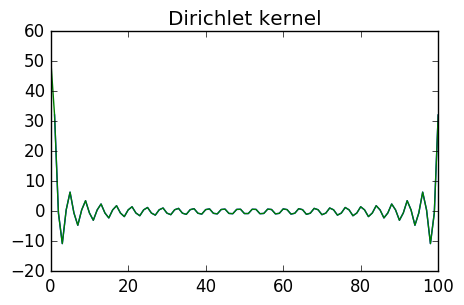

In [18]:
W = sum(hs2)
dirvals = sin(pi*W*ns/N)./sin(pi*ns/N)

fig = figure("Dirichlet tryout", figsize=(5,3))
ax = gca()
title("Dirichlet kernel")
plot(ns, dirvals)
plot(ns, cs2)
show()

BOOM! Perfect match! It even has the symmetry we didn't get from the $\mathrm{sinc}$. Makes sense, since this Dirichlet kernel is N-periodic, so the peak at the end is to be expected, it's the "negative $n$" one. The $\mathrm{sinc}$ is the solution for $N\to \infty$, so it doesn't have this periodicity. Also, the subtle differences between the $\mathrm{sinc}$ and our Dirichlet kernel also fixed the amplitude discrepancies.

A job well done! I hope you're feeling more confident about the FFT now! (As well as plotting in Julia, and keeping notebooks in Jupyter. A good evening indeed!)

## Little bonus, timing!
Just for fun, here's a test of the `@time` macro! It also displays how much memory is used. It's pretty cool!

In [29]:
N = 300000
xs3 = xs2 = collect(linspace(0.0, L*(1-1/N), N)) # Correct sampling
hs3 = hat2(xs3)
@time fft(hs3);

  0.026625 seconds (66 allocations: 9.157 MB, 8.17% gc time)
